In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [ ]:
from dygie.data.dataset_readers.pwc_json import *

In [ ]:
reader = PwCJsonReader(max_span_width=10, context_width=1)

In [ ]:
instances = list(reader.read("../data/pwc_split_on_labeled/dev.jsonl"))

In [157]:
import json
instances = [json.loads(s) for s in open('../data/pwc_split_on_labeled/train.jsonl')]
# instances += [json.loads(s) for s in open('../data/pwc_split_on_labeled/dev.jsonl')]
# instances += [json.loads(s) for s in open('../data/pwc_split_on_labeled/test.jsonl')]

In [ ]:
from scripts.analyse_pwc_entity_results import *
from collections import defaultdict
distances = []

In [ ]:
for ins in instances:
    for rel in ins["n_ary_relations"]:
        rel = Relation(*rel)._asdict()
        for r1, r2 in binary_relations:
            rel_r1, rel_r2 = rel[r1], rel[r2]
            spans_r1 = ins["coref"].get(rel_r1, [])
            spans_r2 = ins["coref"].get(rel_r2, [])

            if len(spans_r1) == 0 or len(spans_r2) == 0:
                continue
            distances.append(
                {
                    "rel": (r1, r2),
                    "dist": min([abs((s1[0] + s1[1]) / 2 - (s2[0] + s2[1]) / 2) for s1 in spans_r1 for s2 in spans_r2]),
                }
            )

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(distances)

In [ ]:
sns.pointplot(x='rel', y='dist', data=df)
plt.xticks(rotation=90)

In [ ]:
instances[0]['n_ary_relations']

In [ ]:
from scripts.analyse_pwc_entity_results import *

In [ ]:
from baseline.relation_baseline import compute_metrics, generate_relations
a, b, c , d, e = compute_metrics(instances)

In [ ]:
results = pd.DataFrame(e)

In [ ]:
results['precision_all'] = results['match_all'] / results['pred_all']
results['recall_all'] = results['match_all'] / results['true']
results['f1_all'] = (2*results['precision_all']*results['recall_all']) / (results['precision_all'] + results['recall_all'])

In [ ]:
import seaborn as sns

In [ ]:
sns.regplot(results['n_ent'], results['precision_all'])
sns.regplot(results['n_ent'], results['recall_all'])
# sns.regplot(results['n_ent'], results['f1'])

In [ ]:
ckresults['precision_head'] = results['match_head'] / results['pred_head']
results['recall_head'] = results['match_head'] / results['true']
results['f1_head'] = (2*results['precision_head']*results['recall_head']) / (results['precision_head'] + results['recall_head'])

In [ ]:
sns.regplot(results['n_ent'], results['precision_head'])
sns.regplot(results['n_ent'], results['recall_head'])
# sns.regplot(results['n_ent'], results['f1'])

In [72]:
n_batch = []
n_waste = []
for n in range(6, 7) :
    s = 3
    pairs = sorted(list(set([(i, j) for i in range(n) for j in range(i+1, n)])))

    pairs_done = []
    elem_done = {k:set([k]) for k in range(n)}
    batches = []

    def get_first_incomplete_element(elem_done, elist) :
        elist = set(elist)
        insec = [(k, len(elist & v), len(v)) for k, v in elem_done.items() if k not in elist and len(elem_done[k]) < n]
        insec = sorted(insec, key=lambda x : (x[1], x[2]))
        return insec[0][0]if len(insec) > 0 else -1

    from itertools import combinations

    waste = 0
    while len(set(pairs_done)) < len(pairs) :
        batch = []
        celem = []
        for i in range(s) :
            not_done = get_first_incomplete_element(elem_done, celem)
            if not_done != -1 :
                batch.append(not_done)
                celem.append(not_done)

        batch = sorted(batch)
        for i in range(len(batch)) :
            for j in set(range(len(batch))) - set([i]) :
                elem_done[batch[i]].add(batch[j])

        batches.append(batch)
        for a, b in combinations(range(len(batch)), 2) :
            x = (batch[a], batch[b])
            if x not in pairs_done :
                pairs_done.append(x)
            else :
                waste += 1
        print(batch, waste, pairs_done)
    
    n_batch.append(len(batches))
    n_waste.append(waste)

[0, 1, 2] 0 [(0, 1), (0, 2), (1, 2)]
[3, 4, 5] 0 [(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5)]
[0, 1, 3] 1 [(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5), (0, 3), (1, 3)]
[2, 4, 5] 2 [(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5), (0, 3), (1, 3), (2, 4), (2, 5)]
[0, 1, 4] 3 [(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5), (0, 3), (1, 3), (2, 4), (2, 5), (0, 4), (1, 4)]
[0, 1, 5] 4 [(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5), (0, 3), (1, 3), (2, 4), (2, 5), (0, 4), (1, 4), (0, 5), (1, 5)]
[2, 3] 4 [(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5), (0, 3), (1, 3), (2, 4), (2, 5), (0, 4), (1, 4), (0, 5), (1, 5), (2, 3)]


In [64]:
import matplotlib.pyplot as plt
import numpy as np

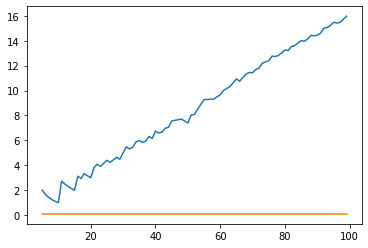

In [71]:
# plt.plot(range(5, 100), n_waste)
# plt.plot(range(5, 100), n_batch)
plt.plot(range(5, 100), np.array(n_batch)*s/ np.array(range(5, 100)))
plt.plot(range(5, 100), [1 / 10] * len(range(5, 100)))